# dezero
밑바닥부터 시작하는 딥러닝 3편에서 구현한 딥러닝 프레임워크 설치 필요

In [197]:
!pip install dezero

# 문제해결
설치 된 dezero import 시 np.int, np.float 데이터타입 문제로 import 가 되지 않는 문제가 발생.  
numpy 디펜던시에 해당하는 문제는 아닌 듯, 깨끗한 환경에서 dezero로 설치해도 문제 발생  
검색을 통해 문제 해결방법 찾았음.

In [198]:
# import error 발생 시 해결방법
import numpy as np
np.int = np.int32
np.float = np.float32
np.bool = np.bool_
import matplotlib.pyplot as plt

# dezero 모듈 import
from dezero import Model # 모델 구성을 위해 필요한 상위클래스, 토치와 사용방법 같음
from dezero import optimizers # 최적화 함수
import dezero.layers as L # 모델 layer 구성을 위한 함수
import dezero.functions as F # functions

# dezero layer 먼저 알아보자

In [165]:
# dezero 패키지의 Layer 모듈의 Linear 함수
# y = Xw + b
L.Linear(out_size, nobias=False, dtype=np.float32, in_size=None)
# 출력 사이즈, 편향 사용여부, 데이터타입, 입력 사이즈

linear = L.Linear(10) # 출력shape 설정

batch_size, input_size = 100, 5 # 데이터갯수, iuput_layer shape(설명변수 갯수)
X  = np.random.randn(batch_size, input_size) # (행, 열) 갯수만큼 0, 1 사이 실수 무작위 설정

y = linear(X) # 입력값 밀어넣고 선형모델화

print(X.shape, linear.W.shape, y.shape)
# 입력데이터 X = (100, 5)
# 연산을 위한 w의 shape은 X와 연산이 가능한 행렬사이즈여야 함 (5, None) 이 아웃 사이즈를 자동으로 설정
# 결국 Xw (100, 5) (5, 10) 행렬곱 연산 후 나오는 shape은 데이터 갯수, 아웃풋 사이즈와 같은 (100, 10)을 y값으로 갖음.

(100, 5) (5, 10) (100, 10)


# layer를 사용한 비선형데이터 학습

0번 데이터 학습 시 오차 0.7052761218259235
1번 데이터 학습 시 오차 0.3003701313918203
2번 데이터 학습 시 오차 0.297499567488278
3번 데이터 학습 시 오차 0.2889006457122207
4번 데이터 학습 시 오차 0.2446489204739949
5번 데이터 학습 시 오차 0.12451807880805835
6번 데이터 학습 시 오차 0.09085901283314948
7번 데이터 학습 시 오차 0.08941353239938182
8번 데이터 학습 시 오차 0.08898249557211539
9번 데이터 학습 시 오차 0.08865209688642964


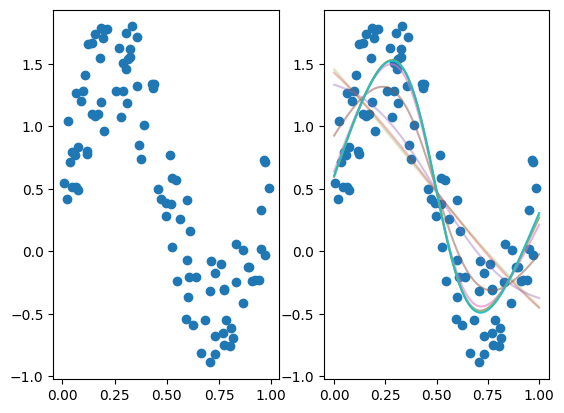

<Figure size 1000x500 with 0 Axes>

In [166]:
# 모델 설정
class TwoLayerNet(Model): # 파라메터로 전달받는 Model클래스를 상속
    def __init__(self, hidden_size, out_size):
        super().__init__() # super() 가 Model class, 초기화 함수를 가져다 씀
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)

    def forward(self, x): # 순전파 설정
        y = F.sigmoid(self.l1(x)) # 1번 레이어 결과값을 시그모이트 함수 파라메터로 전달
        y = self.l2(y) # 다시 2번 레이어의 입력값으로 사용
        # 예측문제이기에 마지막 activation 함수는 없음
        return y

# 데이터셋 생성
np.random.seed(42)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

lr = 0.2 # 학습률
iters = 10000 # 학습횟수

model = TwoLayerNet(10, 1) # (1, 10, 1) 모델 구조

# 데이터 시각화 및 학습과정 시각화
fig, (ax1, ax2) = plt.subplots(1, 2)
fig = plt.figure(figsize=(10, 5))
ax1.scatter(x.mean(axis=1), y)
ax2.scatter(x.mean(axis=1), y)

for i in range(iters):
    y_pred = model.forward(x) # 순전파 y값 계산
    loss = F.mean_squared_error(y, y_pred) # cost function 최소자승법

    model.cleargrads() # 기존 w 삭제
    loss.backward() # 미분값 계산
    
    for p in model.params():
        p.data -= lr * p.grad.data # 미분값 역부호 방향으로 w 업데이트
    if i % 1000 == 0:
        print(f'{int(i / 1000)}번 데이터 학습 시 오차 {loss.data}')
        ax2.plot(np.linspace(0, 1, 100), model.forward(np.linspace(0, 1, 100).reshape(100, 1)).data, alpha=(0 + (i / 1000 * 0.1)))

# Q 함수 신경망 구현

## gridworld import

In [170]:
import gridworld_render as render_helper

class GridWorld:
    
    def __init__(self):
        self.action_space = [0, 1, 2, 3] # action index
        
        self.action_meaning = {0:'업', 
                               1:'다운',
                               2:'왼쪽',
                               3:'오른쪽'
        } # name of action
        
        self.reward_map = np.array(
        [[0, 0, 0, 1],
         [0, None, 0, -1],
         [0, 0, 0, 0]]
        ) # reward in space
        
        self.goal_state = (0, 3) # 목표
        self.wall_state = (1, 1) # 벽 좌표
        self.start_state = (2, 0) # 시작 좌표
        self.agent_state = self.start_state # 에이전트 초기 좌표
        
    @property
    def height(self):
        return len(self.reward_map)

    @property
    def width(self):
        return len(self.reward_map[0])

    @property
    def shape(self):
        return self.reward_map.shape
    
    def actions(self):
        return self.action_space
    
    def states(self): # iterable 인스턴스로 생성
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)
                
    def next_state(self, state, action):
        # 이동위치 계산
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)] # 업, 다운, 왼쪽, 오른쪽을 행렬 인덱스에서 표현
        move = action_move_map[action] # 액션 인덱스에 따라 움직임 설정
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state
        
        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state:
            next_state = state
        
        return next_state
    
    def reward(self, state, action, next_state): # r(s, a, s')
        return self.reward_map[next_state]

    def render_v(self, v=None, policy=None, print_value=True): # V, pi 전달하여 상태공간 시각화 함수
        renderer = render_helper.Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True): # 이번에는 안쓰임
        renderer = render_helper.Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_q(q, print_value)
        
    def step(self, action): # 에이전트가 행동하도록 하여 샘플 데이터를 얻도록 함
        state = self.agent_state
        next_state = self.next_state(state, action)
        reward = self.reward(state, action, next_state)
        done = (next_state == self.goal_state)

        self.agent_state = next_state
        return next_state, reward, done
    
    def reset(self): # 환경을 초기 상태로 재설정하는 메서드
        self.agent_state = self.start_state
        return self.agent_state

## 카테고리컬 데이터 학습을 위한 one-hot-encoding 함수 제작

In [171]:
# 카테고리컬 데이터 학습을 위한 one-hot-encoding 함수 제작
def one_hot(state):
    HEIGHT, WIDTH = 3, 4 # 3 X 4 상태공간
    vec = np.zeros(HEIGHT * WIDTH, dtype=np.float64) # 12개의 원소를 갖는 0 벡터 생성

    y, x = state # 튜플로 전달받아 unpack
    idx = WIDTH * y + x # state의 인덱스 생성
    vec[idx] = 1.0 # 현재 state만 1로

    return vec[np.newaxis, :] # 축 추가

## q모델 구현

In [192]:
class QNet(Model):
    def __init__(self):
        super().__init__()
        # 입력 값은 state가 one hot encoding 된 (1, 12) 형태
        self.l1 = L.Linear(100)
        self.l2 = L.Linear(4)
    # (1, 12) (12, 100) (100, 4) (4, 1) 구조


    def forward(self, x):
        x = F.relu(self.l1(x)) # activation relu
        x = self.l2(x)
        return x

## qlearning Agent 구현

In [199]:
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.lr = 0.01
        self.epsilon = 0.1
        self.action_size = 4

        self.qnet = QNet()
        self.optimizer = optimizers.SGD(self.lr) # 스토캐스틱 그래디언트 디센트를 최적화 방법으로 사용 학습률 파라메터로 받음
        self.optimizer.setup(self.qnet) # 모델 집어넣고 최적화 함수 이거 쓰겠다

    def get_action(self, state):
        # eps에 따라 랜덤 액션 취함
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            qs = self.qnet(state)
            return qs.data.argmax() # 랜덤이 아닌결우 q함수를 최대화 시키는 액션 선택
        
    def update(self, state, action, reward, next_state, done):
        # q함수 갱신
        if done:
            next_q = np.zeros(1) # 에피소드 완료 시 함수가치 0
        else:
            next_qs = self.qnet(next_state)
            next_q = next_qs.max(axis=1) # 책에서는 정답 레이블이라 하는데 정확하게 의미를 모르겠음
            next_q.unchain() # 미분 계산 안함
        
        target = self.gamma * next_q + reward # 목표설정
        qs = self.qnet(state)
        q = qs[:, action]
        loss = F.mean_squared_error(target, q)

        self.qnet.cleargrads() # 기존 w 삭제
        loss.backward() # 미분값 계산
        self.optimizer.update() # w 업데이트

        return loss.data

In [206]:
env = GridWorld()
agent = QLearningAgent()

episodes = 3000
loss_history = []

for episode in range(episodes):
    state = env.reset()
    state = one_hot(state)
    total_loss, cnt = 0, 0
    done = False

    while not done: # 한 에피소드에 12번 데이터 밀어넣고 작업
        action = agent.get_action(state) # 액션 빼오고
        next_state, reward, done = env.step(action) # 다음 state 설정
        next_state = one_hot(next_state)

        loss = agent.update(state, action, reward, next_state, done) # q 함수 갱신
        total_loss += loss
        cnt += 1
        state = next_state

        average_loss = total_loss / cnt
        loss_history.append(average_loss)

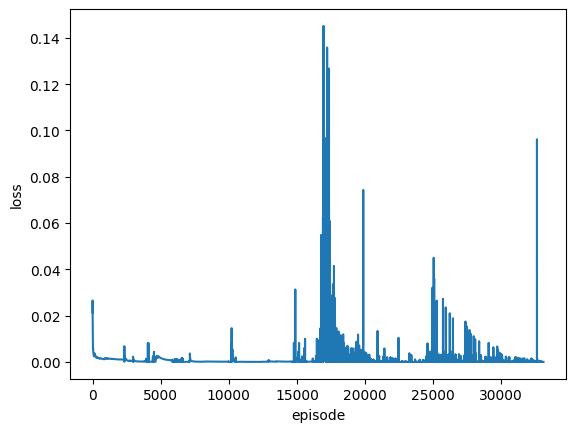

In [207]:
plt.xlabel('episode')
plt.ylabel('loss')
plt.plot(range(len(loss_history)), loss_history)
plt.show()

/var/folders/y3/zdmk74112d31fl8c0w8_sg5h0000gn/T/ipykernel_23666/3577325236.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state, action] = float(q.data)


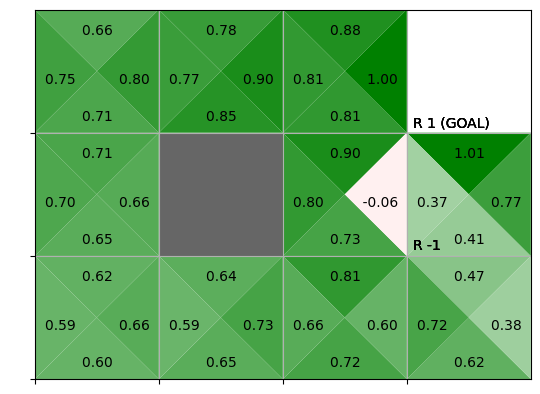

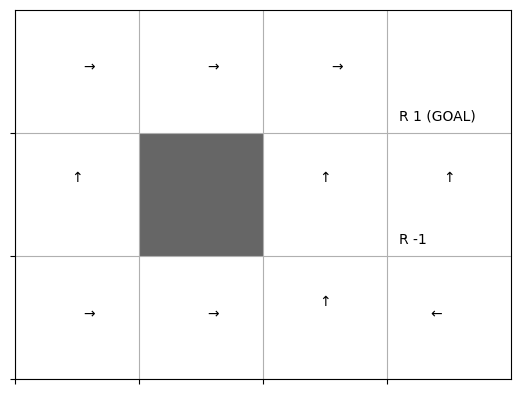

In [208]:
Q = {}
for state in env.states():
    for action in env.action_space:
        q = agent.qnet(one_hot(state))[:, action]
        Q[state, action] = float(q.data)
env.render_q(Q)